# Endometrium analysis - clusters visualization

In [139]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './data/cellphoneDB_organoids_NI/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

scanpy==1.4.4 anndata==0.6.22rc1 umap==0.3.10 numpy==1.17.5 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

# Prepare INPUT

## Load andata

In [140]:
adata = sc.read('data/organoids-all-TC-keep-ccg_Luzprocessing.h5ad')
adata.X.shape

(53720, 2803)

### Load cell clusters annotation

In [141]:
meta = pd.read_csv('figures_both_organoid/barcode_metadata.csv')
meta = meta.set_index('index')

### Transfer cluster annotation labels

Remove barcodes not in meta

In [142]:
barcodes = meta.index.tolist()
adata = adata[[ i in barcodes for i in adata.obs_names]]
adata.X.shape

(53720, 2803)

Now transfer labels

Trying to set attribute `.obs` of view, making a copy.
... storing 'clusters' as categorical


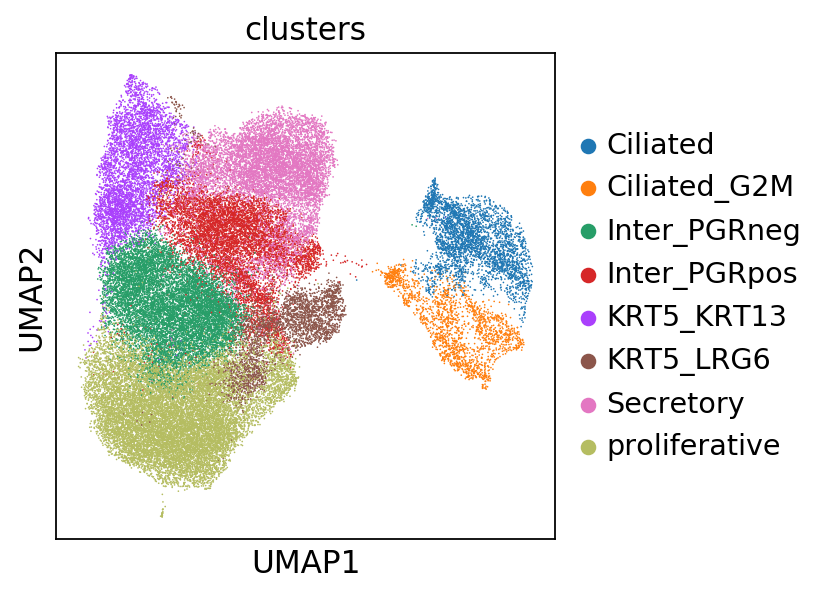

In [143]:
cell_annot = meta['clusters'].to_dict()
adata.obs['clusters'] = [ cell_annot[str(i)] for i in adata.obs_names ]
sc.pl.umap(adata, color=['clusters'])

In [144]:
adata.obs['clusters'].cat.categories

Index(['Ciliated', 'Ciliated_G2M', 'Inter_PGRneg', 'Inter_PGRpos',
       'KRT5_KRT13', 'KRT5_LRG6', 'Secretory', 'proliferative'],
      dtype='object')

## Save gene expression 

Generate the normalized but not log transformed matrix

In [145]:
adata.X.shape

(53720, 2803)

In [146]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
adata_count.X.shape

(53720, 24241)

In [147]:
'RSPO1' in adata_count.var_names

False

In [148]:
'HGF' in adata_count.var_names

False

In [149]:
'NOG' in adata_count.var_names

True

In [150]:
'FGF10' in adata_count.var_names

False

In [151]:
'EGF' in adata_count.var_names

True

Use only genes in cellphoneDB to speed up processes

In [152]:
# # load cellphoneDB genes
# genes_df = pd.read_csv('~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv')
# genes_in_cellphoneDB = list(genes_df['hgnc_symbol'])
# # filter genes in cellphoneDB
# adata_count.var['is_in_cellphoneDB'] = [ i in genes_in_cellphoneDB for i in adata_count.var_names ]
# print(adata_count.var['is_in_cellphoneDB'].value_counts(normalize=True))
# is_in_cellphoneDB = adata_count.var["is_in_cellphoneDB"]
# adata_count = adata_count[:, is_in_cellphoneDB]
# adata_count.X.shape

Downsample clusters with > n cells - take n cells

In [153]:
print(adata_count.obs['clusters'].values.describe())

               counts     freqs
categories                     
Ciliated         3322  0.061839
Ciliated_G2M     1888  0.035145
Inter_PGRneg    10377  0.193168
Inter_PGRpos     7076  0.131720
KRT5_KRT13       4778  0.088943
KRT5_LRG6        2948  0.054877
Secretory        8217  0.152960
proliferative   15114  0.281348


In [154]:
import random
from itertools import chain

# Find clusters with > n cells
n = 2000
cluster_counts = adata_count.obs['clusters'].values.describe()
cl2downsample = cluster_counts.index[ cluster_counts['counts'] > n ]

# save all barcode ids from small clusters
holder = []
holder.append( adata_count.obs_names[[ i not in cl2downsample for i in adata_count.obs['clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = adata_count[[ i == cl for i in adata_count.obs['clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
adata_count = adata_count[[ i in samples for i in adata_count.obs_names ]]
adata_count.X.shape

Ciliated
Inter_PGRneg
Inter_PGRpos
KRT5_KRT13
KRT5_LRG6
Secretory
proliferative


(15888, 24241)

In [155]:
print(adata_count.obs['clusters'].values.describe())

               counts     freqs
categories                     
Ciliated         2000  0.125881
Ciliated_G2M     1888  0.118832
Inter_PGRneg     2000  0.125881
Inter_PGRpos     2000  0.125881
KRT5_KRT13       2000  0.125881
KRT5_LRG6        2000  0.125881
Secretory        2000  0.125881
proliferative    2000  0.125881


Save as csv

In [156]:
t = adata_count.X.toarray().T
# Set cell ids as column index and gene ids as row index
df_expr_matrix = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)
## ADD RSPO1, HGF, and FGF10 rows TO ACCOUNT FOR THE MEDIA
df_expr_matrix.loc['RSPO1'] = 0
df_expr_matrix.loc['HGF'] = 0
df_expr_matrix.loc['FGF10'] = 0
## ADD 5 COLUMN TO ACCOUNT FOR THE MEDIA
df_expr_matrix['Media_1'] = [10] * df_expr_matrix.shape[0]
df_expr_matrix['Media_2'] = [10] * df_expr_matrix.shape[0]
df_expr_matrix['Media_3'] = [10] * df_expr_matrix.shape[0]
df_expr_matrix['Media_4'] = [10] * df_expr_matrix.shape[0]
df_expr_matrix['Media_5'] = [10] * df_expr_matrix.shape[0]
df_expr_matrix.to_csv('data/cellphoneDB_organoids_NI/counts.csv')

## Save meta

In [157]:
## ADD 5 cells TO ACCOUNT FOR THE MEDIA
cells = list(adata_count.obs.index)
cells.append('Media_1')
cells.append('Media_2')
cells.append('Media_3')
cells.append('Media_4')
cells.append('Media_5')
cell_type = [ 'celltype_'+str(i) for i in adata_count.obs['clusters']]
cell_type.append('Media')
cell_type.append('Media')
cell_type.append('Media')
cell_type.append('Media')
cell_type.append('Media')

In [158]:
df_meta = pd.DataFrame(data={'Cell':cells,
                             'cell_type':cell_type })

df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('data/cellphoneDB_organoids_NI/meta.tsv', sep = '\t')

# Run cellphoneDB

``
source ~/cpdb-venv/bin/activate
``

## Create database
``
cellphonedb database generate 
    --result-path database 
    --user-gene ~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv 
    --user-complex ~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv 
    --user-interactions ~/farm/CellPhoneDB-data_smallmolecules/data/sources/interaction_curated.csv
``

## Run cellphone without statistical analysis - just get expressed interactions
``
cellphonedb method analysis 
    /home/jovyan/farm/endometrium/data/cellphoneDB_organoids_NI/meta.tsv 
    /home/jovyan/farm/endometrium/data/cellphoneDB_organoids_NI/counts.csv 
    --database /home/jovyan/farm/endometrium/data/cellphoneDB/database/cellphonedb_user_2020-04-27-11_59.db 
    --counts-data hgnc_symbol 
    --output-path /home/jovyan/farm/endometrium/data/cellphoneDB_organoids_NI/
    --threshold 0
``


# Compute DEGs

Process data to run limma

In [159]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

               counts     freqs
categories                     
Ciliated         3322  0.061839
Ciliated_G2M     1888  0.035145
Inter_PGRneg    10377  0.193168
Inter_PGRpos     7076  0.131720
KRT5_KRT13       4778  0.088943
KRT5_LRG6        2948  0.054877
Secretory        8217  0.152960
proliferative   15114  0.281348


(53720, 24241)

Downsample clusters with > n cells - take n cells

In [160]:
import random
from itertools import chain

# Find clusters with > n cells
n = 5000
cluster_counts = adata_count.obs['clusters'].values.describe()
cl2downsample = cluster_counts.index[ cluster_counts['counts'] > n ]

# save all barcode ids from small clusters
holder = []
holder.append( adata_count.obs_names[[ i not in cl2downsample for i in adata_count.obs['clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = adata_count[[ i == cl for i in adata_count.obs['clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
adata_count = adata_count[[ i in samples for i in adata_count.obs_names ]]
adata_count.X.shape

Inter_PGRneg
Inter_PGRpos
Secretory
proliferative


(32936, 24241)

In [161]:
print(adata_count.obs['clusters'].values.describe())

               counts     freqs
categories                     
Ciliated         3322  0.100862
Ciliated_G2M     1888  0.057323
Inter_PGRneg     5000  0.151810
Inter_PGRpos     5000  0.151810
KRT5_KRT13       4778  0.145069
KRT5_LRG6        2948  0.089507
Secretory        5000  0.151810
proliferative    5000  0.151810


prepare objects for R

In [162]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [163]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ str(i) for i in adata_count.obs['individual']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,organoids7090723-AAACCTGTCCTATTCA,proliferative,A,A
1,organoids7090723-AAACGGGAGATGTAAC,proliferative,A,A
2,organoids7090723-AAACGGGCACTTCTGC,KRT5_KRT13,A,A
3,organoids7090723-AAACGGGGTACCGAGA,proliferative,A,A
4,organoids7090723-AAACGGGTCTTGTCAT,proliferative,A,A


In [164]:
outpath = str(sc.settings.figdir)

In [165]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [166]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariates = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/Perc/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "organoids7090723.AAACCTGTCCTATTCA" "organoids7090723.AAACGGGAGATGTAAC"
[3] "organoids7090723.AAACGGGCACTTCTGC"
[1] "organoids7090723.AAACCTGTCCTATTCA" "organoids7090723.AAACGGGAGATGTAAC"
[3] "organoids7090723.AAACGGGCACTTCTGC"




Cells in rest 27936


Cells in rest 27936


Cells in rest 29988


Cells in rest 28158


Cells in rest 27936


Cells in rest 27936


Cells in rest 31048


Cells in rest 29614

